### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [32]:
from mmengine import Config
# 加载基础配置文件
cfg = Config.fromfile('../configs/sparse_rcnn/sparse-rcnn_r50_fpn_1x_coco.py')

Given a config that trains a Sparse R-CNN on COCO dataset, we need to modify some values to use it for training on the balloon dataset.

In [33]:
from mmengine.runner import set_random_seed

# 修改数据集元信息（VOC 的 20 个类别）
cfg.metainfo = {
    'classes': (
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
        'bus', 'car', 'cat', 'chair', 'cow', 
        'diningtable', 'dog', 'horse', 'motorbike', 'person', 
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ),
    'palette': [
        (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
        (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
        (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
        (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157)
    ]
}

# 修改数据集路径
cfg.data_root = '/home/spoil/cv/assignment02/task2/data/VOCdevkit/'

# 配置训练数据加载器
cfg.train_dataloader.dataset.type = 'CocoDataset'
cfg.train_dataloader.dataset.ann_file = 'VOC2012/Annotations/instances_train2012.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'VOC2012/JPEGImages/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

# 配置验证数据加载器
cfg.val_dataloader.dataset.type = 'CocoDataset'
cfg.val_dataloader.dataset.ann_file = 'VOC2012/Annotations/instances_val2012.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'VOC2012/JPEGImages/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

# 配置测试数据加载器
cfg.test_dataloader.dataset.type = 'CocoDataset'
cfg.test_dataloader.dataset.ann_file = 'VOC2012/Annotations/instances_test2012.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'VOC2012/JPEGImages/'
cfg.test_dataloader.dataset.metainfo = cfg.metainfo

# 修改评估指标配置
cfg.val_evaluator.ann_file = cfg.data_root + 'VOC2012/Annotations/instances_val2012.json'
cfg.test_evaluator.ann_file = cfg.data_root + 'VOC2012/Annotations/instances_test2012.json'

# 修改模型的类别数（VOC 有 20 个类别）
if hasattr(cfg, 'num_stages'):
    for stage in range(cfg.num_stages):
        cfg.model.roi_head.bbox_head[stage].num_classes = 20
else:
    raise ValueError("cfg.num_stages is not defined in the configuration file")

# 设置工作目录以保存模型和日志
cfg.work_dir = '../experiments/tutorial_exps/sparse_rcnn_voc'

# 保持 1x 训练周期（36 epoch）
cfg.train_cfg.max_epochs = 36

# 设置评估间隔
cfg.train_cfg.val_interval = 1

# 设置检查点保存间隔
cfg.default_hooks.checkpoint.interval = 1

# 调整学习率（原学习率针对 8 个 GPU，单 GPU 需除以 8）
cfg.optim_wrapper.optimizer.lr = 0.02 / 8

# 设置日志记录间隔
cfg.default_hooks.logger.interval = 50

# 设置随机种子以确保结果可重现
set_random_seed(0, deterministic=False)

# 添加 TensorBoard 可视化
cfg.visualizer.vis_backends.append({"type": 'TensorboardVisBackend'})

# 保存修改后的配置文件
config = '../configs/sparse_rcnn/sparse-rcnn_r50_fpn_1x_voc_to_coco.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [34]:
!python ./train.py {config}

05/28 21:08:35 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.21 (main, Dec 11 2024, 16:24:11) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1664011522
    GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
    CUDA_HOME: /usr/local/cuda-12.1
    NVCC: Cuda compilation tools, release 12.1, V12.1.66
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=comput

### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the original Mask R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Mask R-CNN for classification and regression have different weight shape and are not used. The pre-trained weights of mask prediction layer `mask_head.conv_logits` also does not matches the current model and is not used due to similar reason.

Third, after training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 79.6 bbox AP and 81.5 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [17]:
%pip install tensorboard  -i https://mirrors.ustc.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


In [23]:
# load tensorboard in jupyter notebook
%load_ext tensorboard

In [26]:
# see curves in tensorboard
# if you see <IPython.core.display.HTML object> please run it again
%tensorboard --logdir ../experiments/tutorial_exps/sparse_rcnn_voc/20250528_194338

Reusing TensorBoard on port 6007 (pid 163777), started 0:00:00 ago. (Use '!kill 163777' to kill it.)

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [ ]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('/home/spoil/cv/assignment02/task2/data/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg',channel_order='rgb')
checkpoint_file = '../experiments/tutorial_exps/sparse_rcnn_voc/epoch_1.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: tutorial_exps/sparse_rcnn_voc/epoch_1.pth
<DetDataSample(

    META INFORMATION
    img_path: None
    img_id: 0
    batch_input_shape: (800, 1088)
    img_shape: (800, 1067)
    pad_shape: (800, 1088)
    scale_factor: (2.134, 2.1333333333333333)
    ori_shape: (375, 500)

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.0747, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749,
                        0.0749, 0.0749, 0.0749, 0.0749, 0.0747, 0.0749, 0.0749, 0.0749, 0.0747,
                        0.0749, 0.0749, 0.0749, 0.0749, 0.0747, 0.0749, 0.0749, 0.0749, 0.0749,
                        0.0749, 0.0749, 0.0749, 0.0748, 0.0749, 0.0749, 0.0748, 0.0749, 0.0749,
                        0.0749, 0.0749, 0.0747, 0.0749, 0.0749, 0.0748, 0.0749, 0.0749, 0.0749,
                        0.0749, 0.0747, 0.0749, 0.0747, 0.0749, 0.0749, 0.

In [21]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

/home/spoil/.conda/envs/cv/lib/python3.9/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


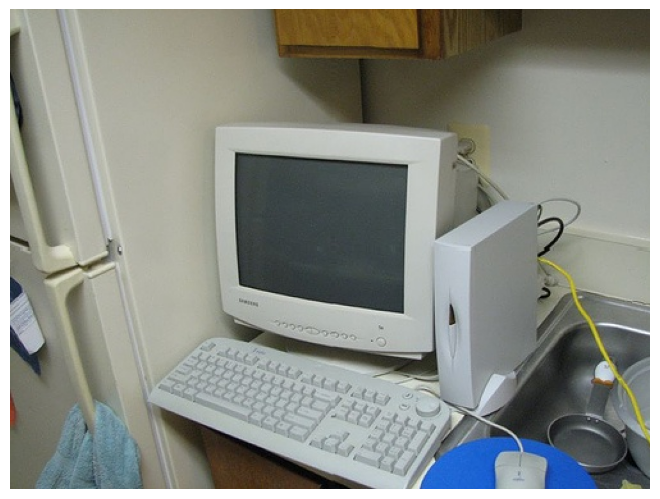

In [22]:
from mmengine.visualization import Visualizer

# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    show=False,
    pred_score_thr=0.5
)
visualizer_now.show()

## What to Do Next?

So far, we have learnt how to test and train Mask R-CNN. To further explore the segmentation task, you could do several other things as shown below:

- Try cascade methods, e.g., [Cascade Mask R-CNN](https://github.com/open-mmlab/mmdetection/tree/master/configs/cascade_rcnn) and [HTC](https://github.com/open-mmlab/mmdetection/tree/master/configs/htc) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md). They are powerful detectors that are ranked high in many benchmarks, e.g., COCO dataset.
- Try single-stage methods, e.g., [K-Net](https://github.com/ZwwWayne/K-Net) and [Dense-RepPoints](https://github.com/justimyhxu/Dense-RepPoints). These two algorithms are based on MMDetection. Box-free instance segmentation is a new trend in the instance segmentation community.
- Try semantic segmentation. Semantic segmentation is also a popular task with wide applications. You can explore [MMSegmentation](https://github.com/open-mmlab/mmsegmentation/); we also provide a [colab tutorial](https://github.com/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb) for semantic segmentation using MMSegmentation.
